In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2009-08-17,NOV,2009-08-17,35.3305,35.6503,34.6309,35.3605,26.4973,5601459,1.522352e+10
2023-03-31,PX,2023-03-31,9.8800,10.1250,9.8300,10.1100,10.1100,213900,1.193444e+09
2010-08-05,LYB,2010-08-05,18.3000,18.3000,18.2000,18.2400,8.8477,252292,1.043100e+10
2017-11-09,REGN,2017-11-09,409.4400,414.0200,396.5300,406.2100,406.2100,942555,4.821660e+10
2009-06-19,V,2009-06-19,61.7000,62.1000,60.8600,61.3700,13.9216,25469748,1.849669e+11


In [3]:
import pandas_ta as ta
from tqdm import tqdm
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = ta.psar(df_ticker['high'],df_ticker['low'],df_ticker['close'],length = 20).fillna(0)
        metrics = metrics.iloc[:,0] - metrics.iloc[:,1]
        results[ticker] = metrics

    except :
        print(ticker)


100%|██████████| 866/866 [05:25<00:00,  2.66it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_4500\1125491087.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe      1.2
Turnover    0.4
biais       1.6
dtype: float64

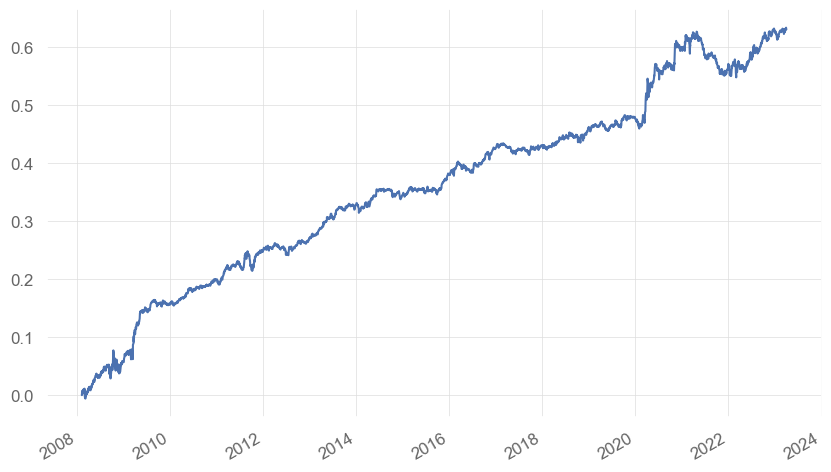

In [14]:
signal = pd.concat(results,axis=1).reindex_like(P).ffill()
signal = signal[P].rolling(2).sum()
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

<Axes: >

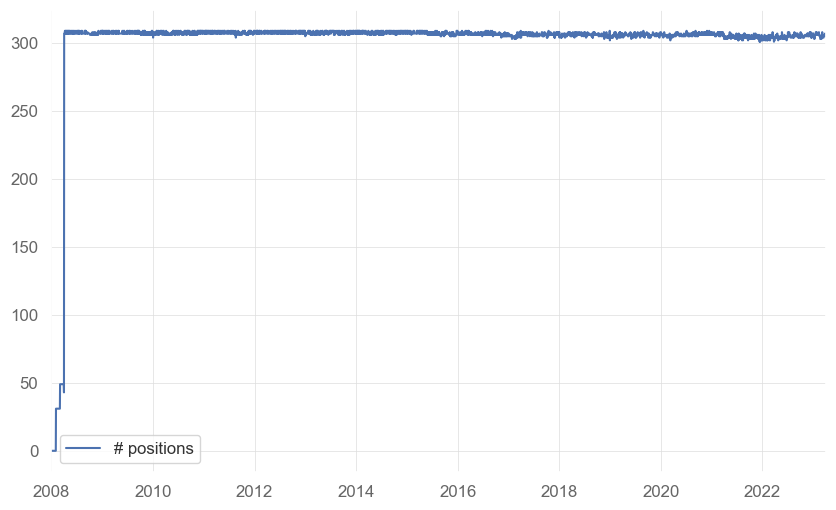

In [15]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

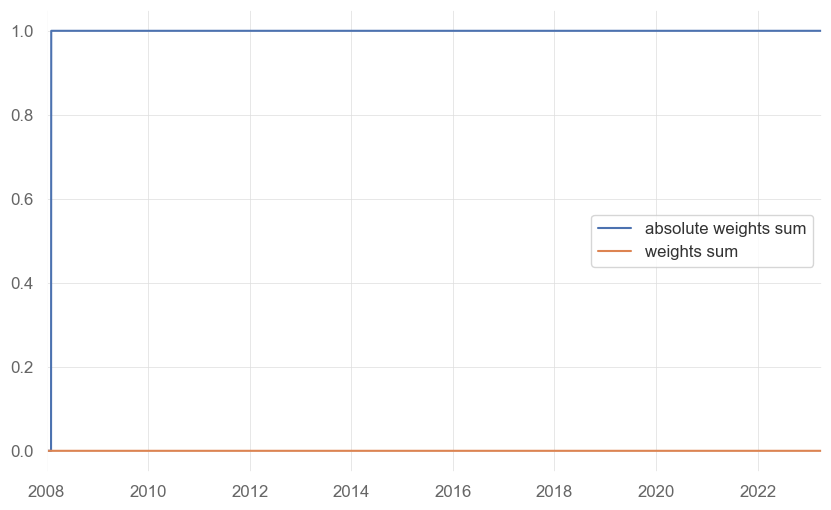

In [16]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)